In [2]:
import sys
import pandas as pd
import numpy as np
import warnings
from agents.agent import DDPG3
from task import LunarLander
warnings.simplefilter('ignore')

LL = LunarLander()
agent = DDPG3(LL, lra=0.001, lrc=0.001, db=0.0000006)›

In [3]:
time_steps = 2000 # set max steps in an episode
steps = np.arange(1, time_steps+1)                            

while True: 
    state = agent.reset_episode() # start a new episode & init. state
    for step in steps: 
        action = agent.act(state) # select actor action given state
        next_state, reward, done = LL.step(action)   # take action on environment
        state = next_state                  # update environment's state in loop
        agent.step(action, reward, next_state, done) # add experience to buffer
        num_exp = agent.num_exp
        if done or step==time_steps or num_exp==agent.buffer: 
            break
    if agent.num_exp==agent.buffer: # break while loop, since PER buffer is full
        break
print('PER Buffer Initialization Completed')

PER Buffer Initialization Completed


In [5]:
num_episodes = 500
time_steps = 2000
best_r = -np.inf
episode_rewards = []
episodes = np.arange(1, num_episodes+1)
steps = np.arange(1, time_steps+1)

for episode in episodes:
    state = agent.reset_episode() # start a new episode
    episode_r = 0
    for step in steps:
        action = agent.act(state)
        next_state, reward, done = LL.step(action)
        abs_e, loss = agent.step(action, reward, next_state, done, True)
        episode_r += reward
        state = next_state
        if done or step==time_steps:
            episode_rewards.append(episode_r)
            best_r = max(best_r, episode_r)
            update_statement = "\rEpisode = {:4d}, reward = {:7.3f} (highest = {:7.3f}), loss = {:7.3f}, err = {:7.3f}"
            print(update_statement.format(episode, episode_r, best_r, loss, abs_e), end='')
            break

    sys.stdout.flush()

Episode =  500, reward =  23.778 (highest = 308.337), loss = 162.606, err =   4.25644

Environment Solved in 493 Episodes


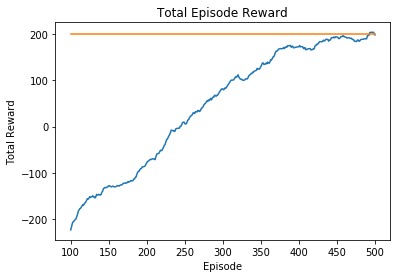

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

episode_reward_avg = moving_average(episode_rewards)
episode_rolling = np.arange(100, len(episode_reward_avg)+100)
episode_solved_idx = episode_rolling[episode_reward_avg > 200][0]
print('Environment Solved in {} Episodes'.format(episode_solved_idx))

plt.plot(episode_rolling, episode_reward_avg)
plt.plot([100,500], [200.,200.])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Episode Reward')
_ = plt.ylim()

In [54]:
import csv
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
# Setup
labels = ['step', 'reward', 'x', 'y', 'x_vel', 'y_vel', 'theta', 
               'theta_vel', 'leg_1', 'leg_2', 'main_eng', 'side_eng']
results = {x : [] for x in labels}
gif_frames = []
file_output = 'data.txt'
done = False    

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    
    test_state = agent.reset_episode()
    for step in steps:
        gif_frames.append(LL.env.render(mode='rgb_array'))
        test_actions = agent.act(test_state)
        next_state, reward, done = LL.step(test_actions)
        test_state = next_state
        to_write = np.concatenate(([step], [reward], list(next_state), test_actions))
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done or step==time_steps:
            LL.env.close()
            break              

Total Episode Reward:  231.04


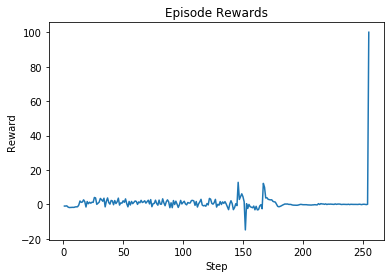

In [57]:
plt.plot(results['step'], results['reward'])
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Episode Rewards')
_ = plt.ylim()

print('Total Episode Reward: {:7.2f}'.format(np.sum(results['reward'])))  

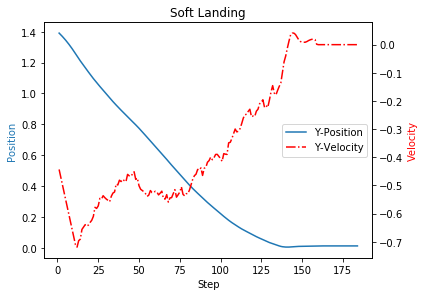

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data

fig, ax1 = plt.subplots()
t_step = results['step']

ax1.set_xlabel('Step')
ax1.set_ylabel('Position', color='tab:blue')
ly = ax1.plot(t_step, results['y'], label='Y-Position')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Velocity', color='r')
lyvel = ax2.plot(t_step, results['y_vel'], '-.', color='r', label='Y-Velocity')
ax2.tick_params(axis='y')

lns = ly+lyvel
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=7)

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.title('Soft Landing')
plt.show()

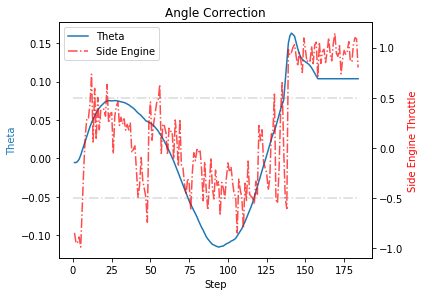

In [44]:
fig, ax3 = plt.subplots()
t_step = results['step']

ax3.set_xlabel('Step')
ax3.set_ylabel('Theta', color='tab:blue')
lt = ax3.plot(t_step, results['theta'], label='Theta')
ax3.tick_params(axis='y')

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax4.set_ylabel('Side Engine Throttle', color='r')
lset = ax4.plot(t_step, results['side_eng'], '-.', alpha=0.7,  color='r', label='Side Engine')
ax4.plot([0,t_step[-1]], [0.5, 0.5], '-.', alpha=0.3, color='grey')
ax4.plot([0,t_step[-1]], [-0.5, -0.5], '-.', alpha=0.3, color='grey')
ax4.tick_params(axis='y')

lnst = lt+lset
labs = [l.get_label() for l in lnst]
ax3.legend(lnst, labs, loc=0)

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.title('Angle Correction')
plt.show()